## Descriptors Retrieval Regression with GIST descriptors

In [5]:
import sys
import os
import random

sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')

In [6]:
from get_data import load_data, load_label, fetch_particular_series, plot_series, load_particular_label

In [7]:
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj

import gist
from skimage import data, transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

import cv2
import numpy as np

### Example of computation of GIST descriptors on specific data 

In [8]:
load_data(4, data_directory="../../data/images/")

array([[[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         ...,

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
         

In [9]:
img1 = fetch_particular_series("009988", 1, data_directory="../../data/images/", grayscale=False)
img2 = fetch_particular_series("009988", 2, data_directory="../../data/images/", grayscale=False)

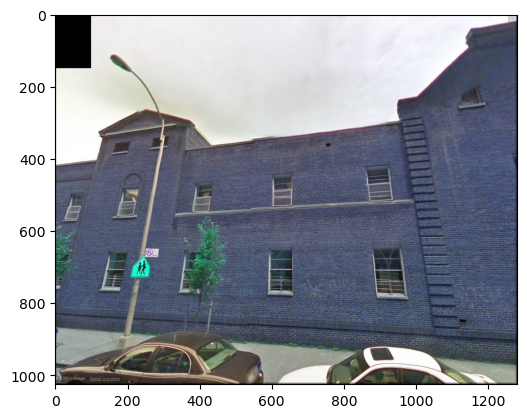

In [10]:
plt.imshow(img1.astype(np.uint8))

In [11]:
descriptor_img1 = gist.extract(img1)
print("Number of GIST descriptors: ", len(descriptor_img1))

Number of GIST descriptors:  960


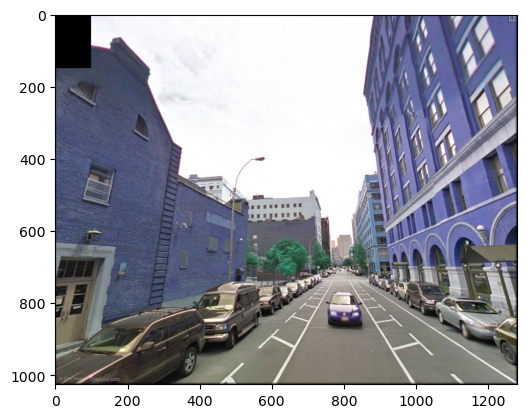

In [12]:
plt.imshow(img2.astype(np.uint8))

In [13]:
descriptor_img2 = gist.extract(img2)
print("Number of GIST descriptors: ", len(descriptor_img2))

Number of GIST descriptors:  960


In [14]:
# we will use OpenCV's BFMatcher (stand for Brute-Force Matcher) to compute matches among descriptors
bf = cv2.BFMatcher()
# matches will be computed using k-Nearest Neighbors method in the descriptors' space
matches = bf.knnMatch(descriptor_img1, descriptor_img2, k=2)

print(f"nombre de matches: {len(matches)}")

nombre de matches: 960


In [15]:
# filter good matches
good = []
for m, n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
        

print(f"nombre de good matches {len(good)}")

nombre de good matches 429


### Inference example on specific data

In [16]:
# start by creating a base of descriptors-label
def create_database_opencv(ids_in_database: list = ["009900", "009902", "009992", "009994", "010207"]):
    """
    Create a mapping between descriptors and labels (Cartesian coordinates).
    """
    database_ids = ids_in_database
    database = {}
    count = 1
    for image_id in database_ids:
        print(f"Creating database: {count}/{len(database_ids)}")
        img = fetch_particular_series(image_id, 1, data_directory="../../data/images/", grayscale=False)
        descriptors = gist.extract(img)
        (x, y) = load_particular_label(image_id, path = "../../data/labels.mat")
        database[(x, y)] = descriptors
        count += 1
    return database

In [17]:
def infer_image_cartesian_coordinates(inference_image, database: dict, thresh: float = 0.5, density_matches: float = 0.4):
    """ 
    Run inference with descriptors-based retrieval regression.
    """
    initial_location = (0.0, 0.0)
    average_x_coord, average_y_coord = [], []
    inference_descriptors = gist.extract(inference_image)
    bf = cv2.BFMatcher()
    nbr_good_matches = []
    at_least_matches = density_matches * 960

    for location, descriptors in database.items():   
        matches = bf.knnMatch(descriptors, inference_descriptors, k=2)
        # filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < thresh*n.distance:
                good_matches.append([m])
                
        # only good matches/filtered matches matter!
        nb_matches = len(good_matches)
        if nb_matches >= at_least_matches:
            nbr_good_matches.append(nb_matches)
            for i in range(nb_matches):
                # pondération par le nombre de matchs
                average_x_coord.append(location[0])
                average_y_coord.append(location[1])
            
    x_infer = np.mean(average_x_coord)
    y_infer = np.mean(average_y_coord)
    
    #print(f"Nombre moyen de good matches par image: {np.mean(nbr_good_matches)}")
    #print(f"Nombre minimal de good matches par image: {min(nbr_good_matches)}")
    if (x_infer is None) or (y_infer is None):
        return initial_location
    else:
        return (x_infer, y_infer)

In [18]:
database_example = create_database_opencv()

Creating database: 1/5
Creating database: 2/5
Creating database: 3/5
Creating database: 4/5
Creating database: 5/5


In [19]:
database_example.keys()

dict_keys([(40.743051, -74.008772), (40.743241, -74.008735), (40.733007, -74.007485), (40.73319, -74.007441), (40.717687, -74.0058)])

In [20]:
# try inference
inference_id = "009993"
image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=False)
(x_true, y_true) = load_particular_label(inference_id, path = "../../data/labels.mat")
(x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database_example)

In [21]:
# évaluation de la performance
print(f"x_true: {x_true}, y_true: {y_true}")
print(f"x_infer: {x_infer}, y_infer: {y_infer}")

x_true: 40.733099, y_true: -74.007463
x_infer: 40.73377867709214, y_infer: -74.00761591166525


In [22]:
def compute_distance(coord_infer: tuple, coord_true: tuple):
    """
    Compute the Cartesian distance between the infered and true coordinates.
    """
    inProj = Proj(init='epsg:4326') # (lat, long)
    outProj = Proj(init='epsg:2154') # Lambert 93
    #x1, y1 = 882408.3,6543019.6
    x_true_l93, y_true_l93 = pyproj.transform(inProj, outProj, x_true, y_true)
    x_infer_l93, y_infer_l93 = pyproj.transform(inProj, outProj, x_infer, y_infer)
    dist = np.sqrt(
        (x_true_l93 - x_infer_l93)**2 + (y_true_l93 - y_infer_l93)**2
    )
    #print(f"Cartesian distance: {round(dist, 1)} meters.")
    return dist

In [23]:
dist = compute_distance((x_infer, y_infer), (x_true, y_true))
print(f"Distance between the ground truth and the location predicted: {dist} m")

Distance between the ground truth and the location predicted: 540.0201810489524 m


/Users/vivienconti/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/vivienconti/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/3j/q8k5jqgd2r9484w_xtb67q980000gn/T/ipykernel_33692/3551545494.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#

### Model Evaluation on problem's data

In [24]:
# on commence par couper le jeu de données en train, test (pas de validation car pas de sélection d'hyperparamètres)
all_filenames = os.listdir("../../data/images")
all_ids = list(set([item.split("_")[0] for item in all_filenames]))
all_ids = all_ids
N = len(all_ids)
# shuffle IDs
random.shuffle(all_ids)
# 20% des données pour le test, 80% pour constituer la base de données
train_test_ratio = 0.9
X_train_ids = all_ids[:int(train_test_ratio*N)]
X_test_ids = all_ids[int(train_test_ratio*N):]
print("Data in database :", N)
print("Data for training :",len(X_train_ids))
print("Data for testing :", len(X_test_ids)) 

Data in database : 444
Data for training : 399
Data for testing : 45


In [25]:
database = create_database_opencv(X_train_ids)

Creating database: 1/399
Creating database: 2/399
Creating database: 3/399
Creating database: 4/399
Creating database: 5/399
Creating database: 6/399
Creating database: 7/399
Creating database: 8/399
Creating database: 9/399
Creating database: 10/399
Creating database: 11/399
Creating database: 12/399
Creating database: 13/399
Creating database: 14/399
Creating database: 15/399
Creating database: 16/399
Creating database: 17/399
Creating database: 18/399
Creating database: 19/399
Creating database: 20/399
Creating database: 21/399
Creating database: 22/399
Creating database: 23/399
Creating database: 24/399
Creating database: 25/399
Creating database: 26/399
Creating database: 27/399
Creating database: 28/399
Creating database: 29/399
Creating database: 30/399
Creating database: 31/399
Creating database: 32/399
Creating database: 33/399
Creating database: 34/399
Creating database: 35/399
Creating database: 36/399
Creating database: 37/399
Creating database: 38/399
Creating database: 39

Creating database: 309/399
Creating database: 310/399
Creating database: 311/399
Creating database: 312/399
Creating database: 313/399
Creating database: 314/399
Creating database: 315/399
Creating database: 316/399
Creating database: 317/399
Creating database: 318/399
Creating database: 319/399
Creating database: 320/399
Creating database: 321/399
Creating database: 322/399
Creating database: 323/399
Creating database: 324/399
Creating database: 325/399
Creating database: 326/399
Creating database: 327/399
Creating database: 328/399
Creating database: 329/399
Creating database: 330/399
Creating database: 331/399
Creating database: 332/399
Creating database: 333/399
Creating database: 334/399
Creating database: 335/399
Creating database: 336/399
Creating database: 337/399
Creating database: 338/399
Creating database: 339/399
Creating database: 340/399
Creating database: 341/399
Creating database: 342/399
Creating database: 343/399
Creating database: 344/399
Creating database: 345/399
C

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
# run inference and compute the average losse
losses = []
count = 1
for inference_id in X_test_ids:
    print(f"Count: {count}/{len(X_test_ids)}")
    image_inference = fetch_particular_series(inference_id, 1, data_directory="../../data/images/", grayscale=False)
    (x_true, y_true) = load_particular_label(inference_id, path = "../../data/labels.mat")
    (x_infer, y_infer) = infer_image_cartesian_coordinates(image_inference, database, thresh=0.55, density_matches=0.54)
    dist = compute_distance((x_infer, y_infer), (x_true, y_true))
    
    if dist > 0:
        losses.append(dist)
    count += 1

Count: 1/45
Count: 2/45
Count: 3/45
Count: 4/45
Count: 5/45
Count: 6/45
Count: 7/45
Count: 8/45
Count: 9/45
Count: 10/45
Count: 11/45
Count: 12/45
Count: 13/45
Count: 14/45
Count: 15/45
Count: 16/45
Count: 17/45
Count: 18/45
Count: 19/45
Count: 20/45
Count: 21/45


/Users/vivienconti/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vivienconti/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Count: 22/45
Count: 23/45
Count: 24/45
Count: 25/45
Count: 26/45
Count: 27/45
Count: 28/45
Count: 29/45
Count: 30/45
Count: 31/45
Count: 32/45
Count: 33/45
Count: 34/45
Count: 35/45
Count: 36/45
Count: 37/45
Count: 38/45
Count: 39/45
Count: 40/45
Count: 41/45
Count: 42/45
Count: 43/45
Count: 44/45
Count: 45/45


In [46]:
average_loss = np.mean(losses)
print("Average loss (in meters) for the GIST descriptors-based retrieval regression method: {} meters.".format(round(average_loss, 2)))

Average loss (in meters) for the GIST descriptors-based retrieval regression method: 8143.27 meters.


In [47]:
DUMMY_LOSS = 8334 # average error in meters of the dummy regression (see baseline-model)
print("The GIST descriptors-based retrieval regression method outperforms the dummy regression by {}%".format(
    round(100*(DUMMY_LOSS - average_loss)/DUMMY_LOSS, 2)
))

The GIST descriptors-based retrieval regression method outperforms the dummy regression by 2.29%
